In [27]:
import nibabel as nib
import numpy as np
import load_confounds

in_cii = '/scratch/dimuthu1/PPMI_project2/derivatives/fmriprep_20_2_1_test_syn_sdc/fmriprep/sub-3116/ses-Month12/func/sub-3116_ses-Month12_task-rest_run-1_space-fsLR_den-91k_bold.dtseries.nii'
cii = nib.load(in_cii)
timeseries = cii.get_fdata()

In [28]:
from load_confounds import Params36
file = "/scratch/dimuthu1/PPMI_project2/derivatives/fmriprep_20_2_1_test_syn_sdc/fmriprep/sub-3116/ses-Month12/func/sub-3116_ses-Month12_task-rest_run-1_space-fsLR_den-91k_bold.dtseries.nii"
confounds = Params36().load(file)

print(np.shape(confounds))

(210, 42)


In [29]:
from nilearn import signal
clean_ts = signal.clean(timeseries, confounds=confounds).T
print(np.shape(clean_ts))

(91282, 210)


In [30]:
clean_ts = clean_ts.T

atlas_L = nib.load('../cfg/L.atlasroi.32k_fs_LR.shape.gii')
atlas_L = atlas_L.darrays[0].data
atlas_R = nib.load('../cfg/R.atlasroi.32k_fs_LR.shape.gii')
atlas_R = atlas_R.darrays[0].data
atlas = np.hstack((atlas_L,atlas_R))

print(atlas)

#atlas = nib.load('../91282_Greyordinates.dscalar.nii').get_fdata()




schaefer_left = nib.load('../cfg/schaefer-1000.L.32k_fs_LR.label.gii').darrays[0].data
schaefer_right = nib.load('../cfg/schaefer-1000.R.32k_fs_LR.label.gii').darrays[0].data
schaefer_LR = np.hstack((schaefer_left,schaefer_right))
labels_LR_no_medialwall = schaefer_LR[atlas==1]

atlas = nib.load('../cfg/91282_Greyordinates.dscalar.nii').get_fdata()
new_1 = clean_ts[:,(atlas[0]==1)]

print(np.shape(new_1))



print(np.shape(labels_LR_no_medialwall))



[1. 1. 1. ... 1. 1. 1.]
(210, 59412)
(59412,)


In [31]:
from brainspace.utils.parcellation import reduce_by_labels
cortex_vals = reduce_by_labels(new_1, labels_LR_no_medialwall, axis=0, red_op='sum')

print(np.shape(new_1))
print(np.shape(cortex_vals))

mean_ts = np.zeros((len(new_1), 1000))
#print(len(clean_ts))

for i in range(0,1000):
    mean_ts[:,i] = np.mean(new_1[:,(labels_LR_no_medialwall==i+1)], axis =1)


print(np.shape(mean_ts))
mean_ts = np.nan_to_num(mean_ts)

(210, 59412)
(210, 999)
(210, 1000)


In [32]:
print(np.shape(atlas))
print(np.shape(clean_ts))

(1, 91282)
(210, 91282)


In [33]:

#fmri_data_ctx = fmri_fdata[:,0:len(schaefer_LR)]

#all = np.zeros((len(fmri_data_ctx), 1))

subctx_dict = {0: (12, 51, 'putamen'),
               1: (11, 50, 'caudate'),
               2: (26, 58, 'accumbens')}

put_L = clean_ts[:,(atlas[0]==12)]
put_R = clean_ts[:,(atlas[0]==51)]
cau_L = clean_ts[:,(atlas[0]==11)]
cau_R = clean_ts[:,(atlas[0]==50)]
acc_L = clean_ts[:,(atlas[0]==26)]
acc_R = clean_ts[:,(atlas[0]==58)]

print(np.shape(put_L))
print(np.shape(acc_L))
subctx_vals = np.concatenate((put_L, put_R, cau_L, cau_R, acc_L, acc_R),axis=1)

print(np.shape(subctx_vals))

(210, 1060)
(210, 135)
(210, 3828)


In [34]:
#combining cortex and sub cortex
print(np.unique(mean_ts))
#combined_ts = np.concatenate((cortex_vals,subctx_vals), axis=1)
combined_ts = np.concatenate((mean_ts,subctx_vals), axis=1)

print(np.shape(combined_ts))

[-3.57662848 -3.38615374 -3.2223603  ...  3.42310753  3.60917215
  3.66205846]
(210, 4828)


In [35]:
from nilearn.connectome import ConnectivityMeasure

correlation_measure = ConnectivityMeasure(kind='correlation')
correlation_matrix = correlation_measure.fit_transform([combined_ts])[0]

print(np.shape(correlation_matrix))

(4828, 4828)


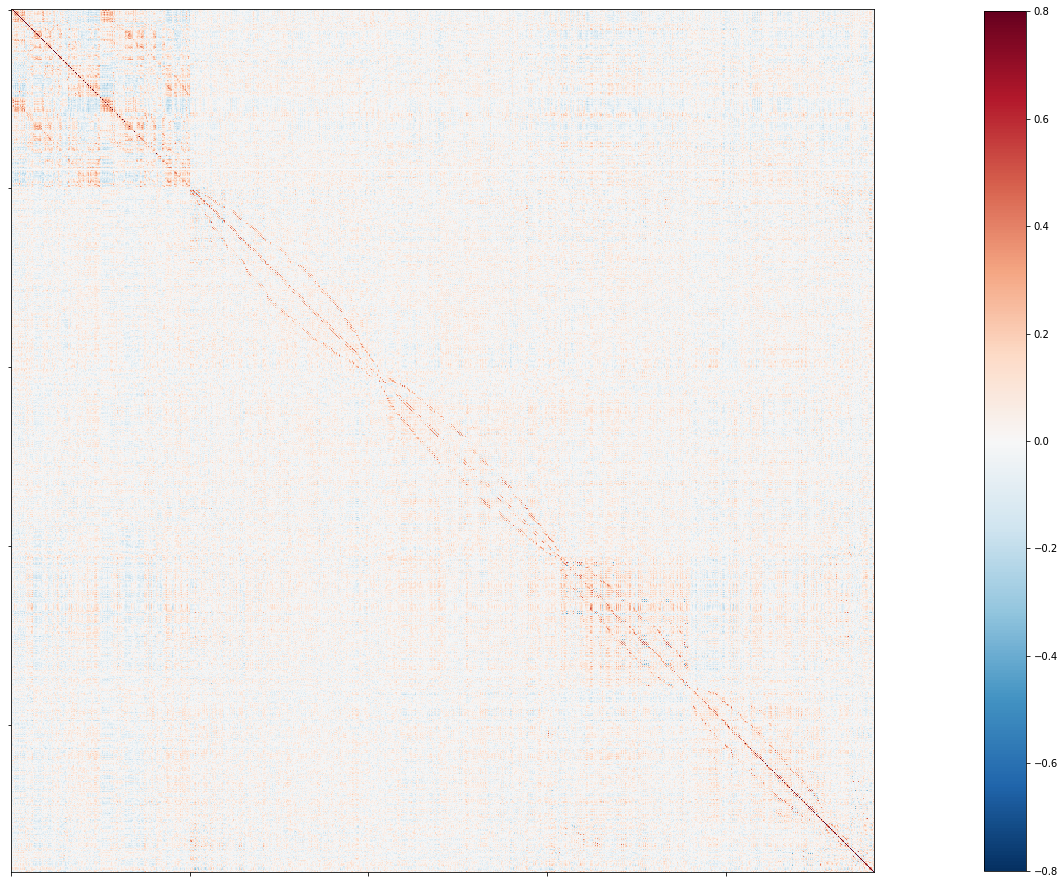

In [36]:
from nilearn import plotting

# Reduce matrix size, only for visualization purposes
#mat_mask = np.where(np.std(correlation_matrix, axis=1) > 0.2)[0]
#c = correlation_matrix[mat_mask][:, mat_mask]

# Create corresponding region names
#regions_list = ['%s_%s' % (h, r.decode()) for h in ['L', 'R'] for r in regions]
#masked_regions = [regions_list[i] for i in mat_mask]


corr_plot = plotting.plot_matrix(correlation_matrix, figure=(15, 15), vmax=0.8, vmin=-0.8)

In [37]:
sliced_matrix = correlation_matrix[:500,1000:]
#slice = arr[0:2,0:2]

print(np.unique(sliced_matrix))


#sliced_matrix = (sliced_matrix+1)/2

print(np.unique(sliced_matrix))

[-0.2924494  -0.28413163 -0.28119858 ...  0.33368067  0.33509329
  0.35117918]
[-0.2924494  -0.28413163 -0.28119858 ...  0.33368067  0.33509329
  0.35117918]


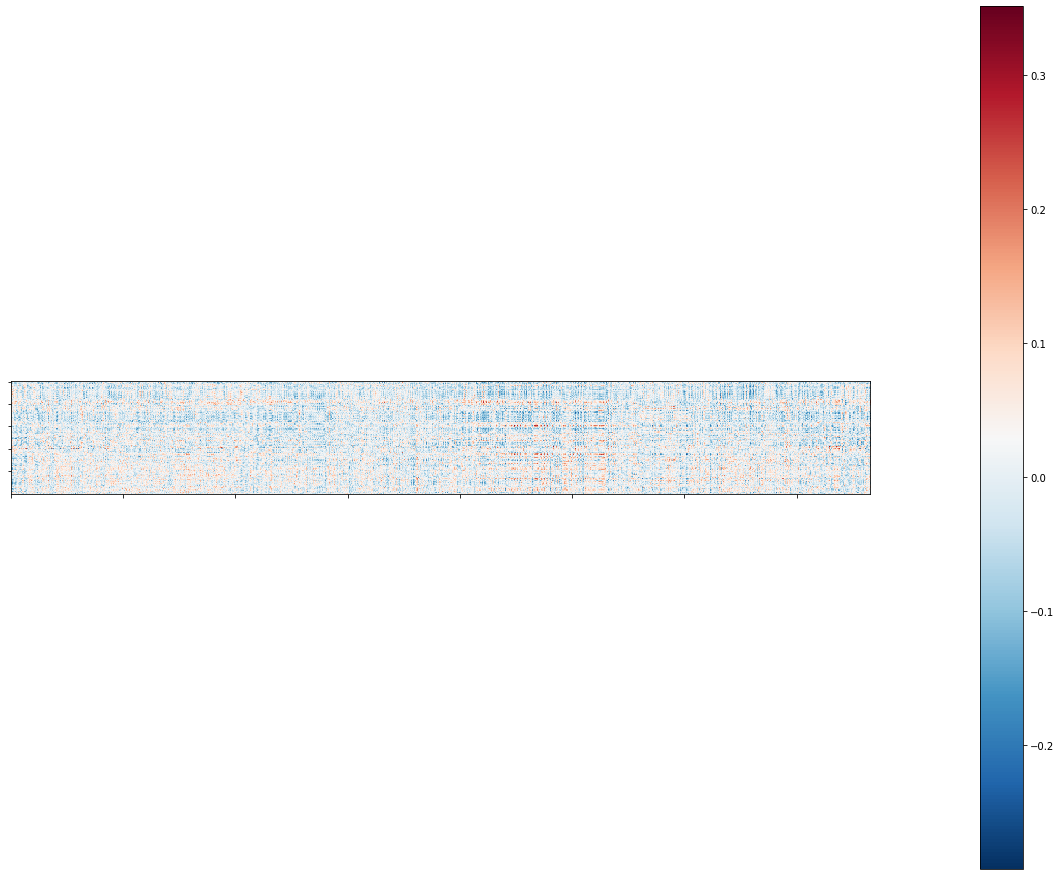

In [38]:
corr_plot = plotting.plot_matrix(sliced_matrix, figure=(15, 15))

[[ 1.          0.21230031  0.08506526 ...  0.23169543  0.18091632
   0.0781144 ]
 [ 0.21230031  1.          0.24683374 ... -0.03245042 -0.10294659
   0.01931843]
 [ 0.08506526  0.24683374  1.         ...  0.31818112  0.37167647
   0.4975476 ]
 ...
 [ 0.23169543 -0.03245042  0.31818112 ...  1.          0.46904806
   0.35192614]
 [ 0.18091632 -0.10294659  0.37167647 ...  0.46904806  1.
   0.52217072]
 [ 0.0781144   0.01931843  0.4975476  ...  0.35192614  0.52217072
   1.        ]]


GradientMaps(alignment=None, approach='dm', kernel=None, n_components=3,
             random_state=0)

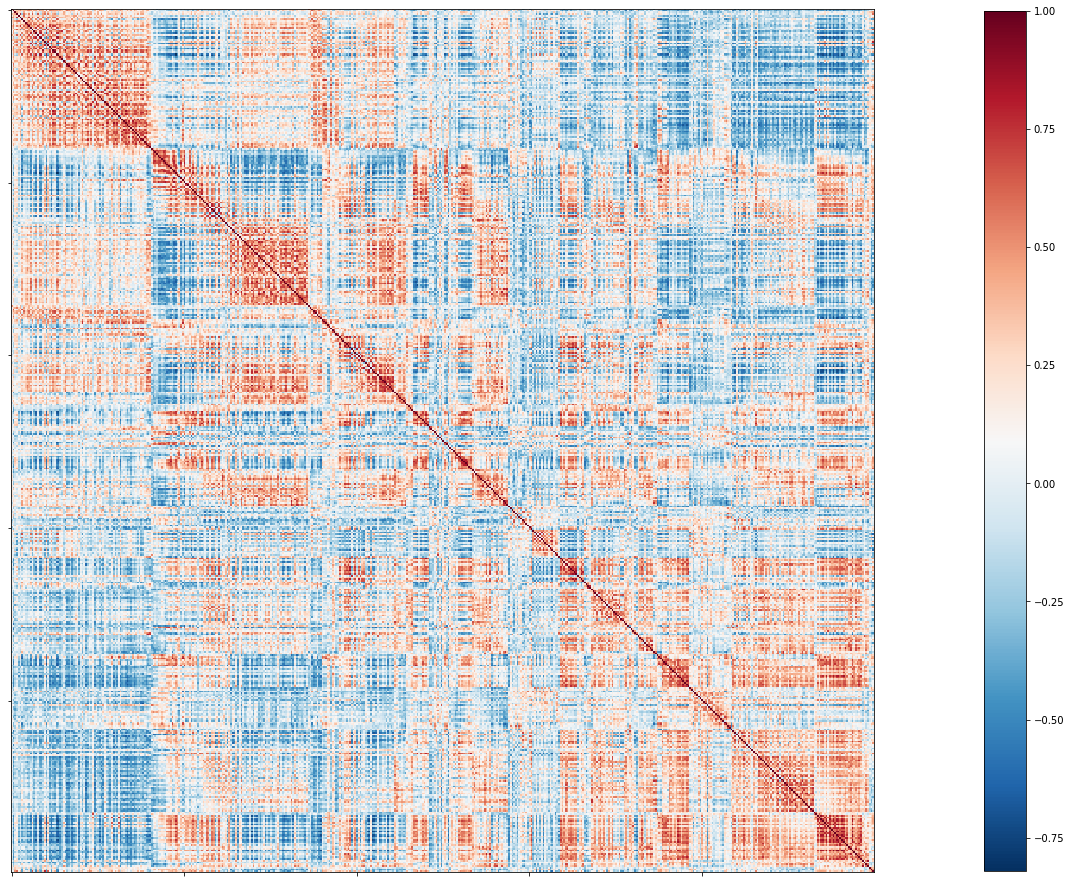

In [39]:
from brainspace.gradient import GradientMaps

from sklearn.metrics.pairwise import cosine_similarity

sim_matrix = cosine_similarity(sliced_matrix, sliced_matrix)

print(sim_matrix)

corr_plot = plotting.plot_matrix(sim_matrix, figure=(15, 15))

gm = GradientMaps(n_components=3, random_state=0)
gm.fit(sim_matrix)

In [40]:
grad_1 = gm.gradients_.T[0]
grad_2 = gm.gradients_.T[1]
grad_3 = gm.gradients_.T[2]



       grad_1    grad_2    grad_3
0    1.002324  0.732438 -0.931138
1    1.311726  0.349317 -0.235770
2    0.582640  1.158925 -1.168050
3    0.799797  1.159871 -1.373730
4    1.287118  0.564919 -0.482975
..        ...       ...       ...
495 -0.798121 -0.846296 -0.288163
496 -0.346750 -0.729367 -0.733239
497  0.160081  1.097803 -0.845348
498 -0.232493  1.415740  0.963488
499 -0.247584  1.006511 -0.812936

[500 rows x 3 columns]


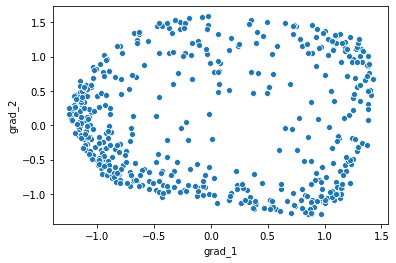

In [41]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


dataset = pd.DataFrame({'grad_1': grad_1, 'grad_2': grad_2, 'grad_3': grad_3})

print(dataset)

sns.scatterplot(x="grad_1", y="grad_2",data = dataset)
